# What is Stable Diffusion?
with 🤗 Diffusers
by **Pedro Cuenca, Patrick von Platen, Suraj Patil, Jeremy Howard**

This notebook introduces Stable Diffusion (SD), an open source text to image model small enough to run in consumer GPUs,
using the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).
Understanding state-of-the-art (SOTA) generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. This notebook shows a glimpse of its main components.

_If you open this notebook in Colab, please uncomment and run the following cell. If you get type errors when generating your first image, please try to upgrade your transformers installation using `pip install --upgrade transformers`_

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

NB: May need to restart kernel after this pip

In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate hf_xet

In [1]:
!pip list | grep -e diffusers -e transformers -e huggingface-hub -e ftfy #-e fastai -e fastdownload #-e torch 

diffusers                 0.33.1
ftfy                      6.3.1
huggingface-hub           0.30.2
transformers              4.52.4


In [2]:
import torch
DEVICE =  'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
FLOATTYPE = torch.float16 if (DEVICE == 'mps' or  DEVICE == 'cuda' ) else torch.float
DEVICE, FLOATTYPE

('mps', torch.float16)

In [3]:
from pathlib import Path
from huggingface_hub import notebook_login
TOKEN = '.cache/huggingface/token'  # '.huggingface'/'token'
if not (Path.home()/TOKEN).exists(): notebook_login()

In [4]:
import logging
logging.disable(logging.WARNING)

---

## The components of Stable Diffusion

There are three main components in latent diffusion.
An autoencoder (VAE), a [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq), and
a text-encoder, e.g., [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).
The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm.
Many different scheduler algorithms can be used for this computation, each having its pros and cons.
For SD we recommend using one of:
[PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default),
[DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py),
[K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).

### Latents and callbacks

**Stable Diffusion (SD)** is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).<br>
General diffusion models are trained to *denoise* random Gaussian noise step by step, to get to a sample of interest, such as an *image*.
A detailed overview of how SD models is in [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).
Diffusion models achieve SOTA results for generating image data, but it is challenging to train models and to use them for inference, because: 
- the reverse denoising process is slow. 
- consume a lot of memory because they operate in pixel space, (expensive for high-resolution images). 

<mark> In **latent diffusion** the model is trained to generate latent (compressed) representations of the images.</mark>
This reduces the RAM and compute complexity by applying diffusion over a smaller _latent_ space, instead of the actual pixel space. 

## Pipeline 
A **"pipeline"** indicates a sequence of steps that when combined complete some task.
HF provides several [diffusion inference pipelines](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/overview), that
allow to start generating images with just a few lines of code. 
By **"inference"** we refer to using an existing model to generate samples (e.g., images), as opposed to **"training"** (or fine-tuning) models using new data.

In [4]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
torch.manual_seed(1);

### Pretrained models
We use the [`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img) 
[`from_pretrained`](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline.from_pretrained) to create the pipeline and download the pretrained weights. 
We use pre-trained models due to the high computational demands of training. 
We use these models for inference, such as with a U-Net that denoises images. 
By iteratively subtracting predicted noise from a noisy image, the model refines its output, like generating an image of a handwritten digit '3'.
<br>
We indicate to use the `fp16` (half-precision) `variant` of the weights, and tell `diffusers` to expect the weights in that format. 
`fp16` performs faster inference with no discernible difference in quality. 
The string passed to `from_pretrained`, ([stable-diffusion-v1-5](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5)), is the repo-id of a pretrained pipeline hosted on [Hugging Face Hub](https://huggingface.co/models);
it can also be a path to a directory containing pipeline weights. 
The weights for all the models in the pipeline will be downloaded and cached the first time we run this cell.

The SD pipeline can send intermediate latents to a callback function we provide, e.g. `latents_callback()` below. 
By running these latents through the image decoder (the `vae` component of the pipeline), 
we can save them to later see how the denoising process progresses and the image unfolds.

Inside the pipeline what is going on is all of the steps (Lesson 9).
The `callback_steps=12` indicates to call `latents_callback(i, t, latents)` every 12 steps, 
to create an image and stick it at the end of the `images` array.
Using a callback we can interact with the pipeline (without needing to rewrite it). 

In [5]:
# ChatGPT v2
model_id = "sd-legacy/stable-diffusion-v1-5" # stable-diffusion-v1-5/stable-diffusion-v1-5

with torch.autocast(DEVICE):
    pipe = StableDiffusionPipeline.from_pretrained(model_id, variant='fp16', torch_dtype=FLOATTYPE).to(DEVICE)
    
vae = pipe.vae
images = []

def latents_callback(step: int, timestep, latents):
    # Decode only first sample in batch
    lat = latents / 0.18215
    img = vae.decode(lat).sample[0]
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(img))
    #print(f"Saved step {step}, timestep {timestep}")

prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(9000)

# Generate and save intermediate images every 12 steps
result = pipe(
    prompt,
    num_inference_steps=50,
    callback=latents_callback,
    callback_steps=12,
)

# Append the final image
images.append(result.images[0])


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/germangoldszmidt/miniforge3/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:899: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/Users/germangoldszmidt/miniforge3/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:905: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

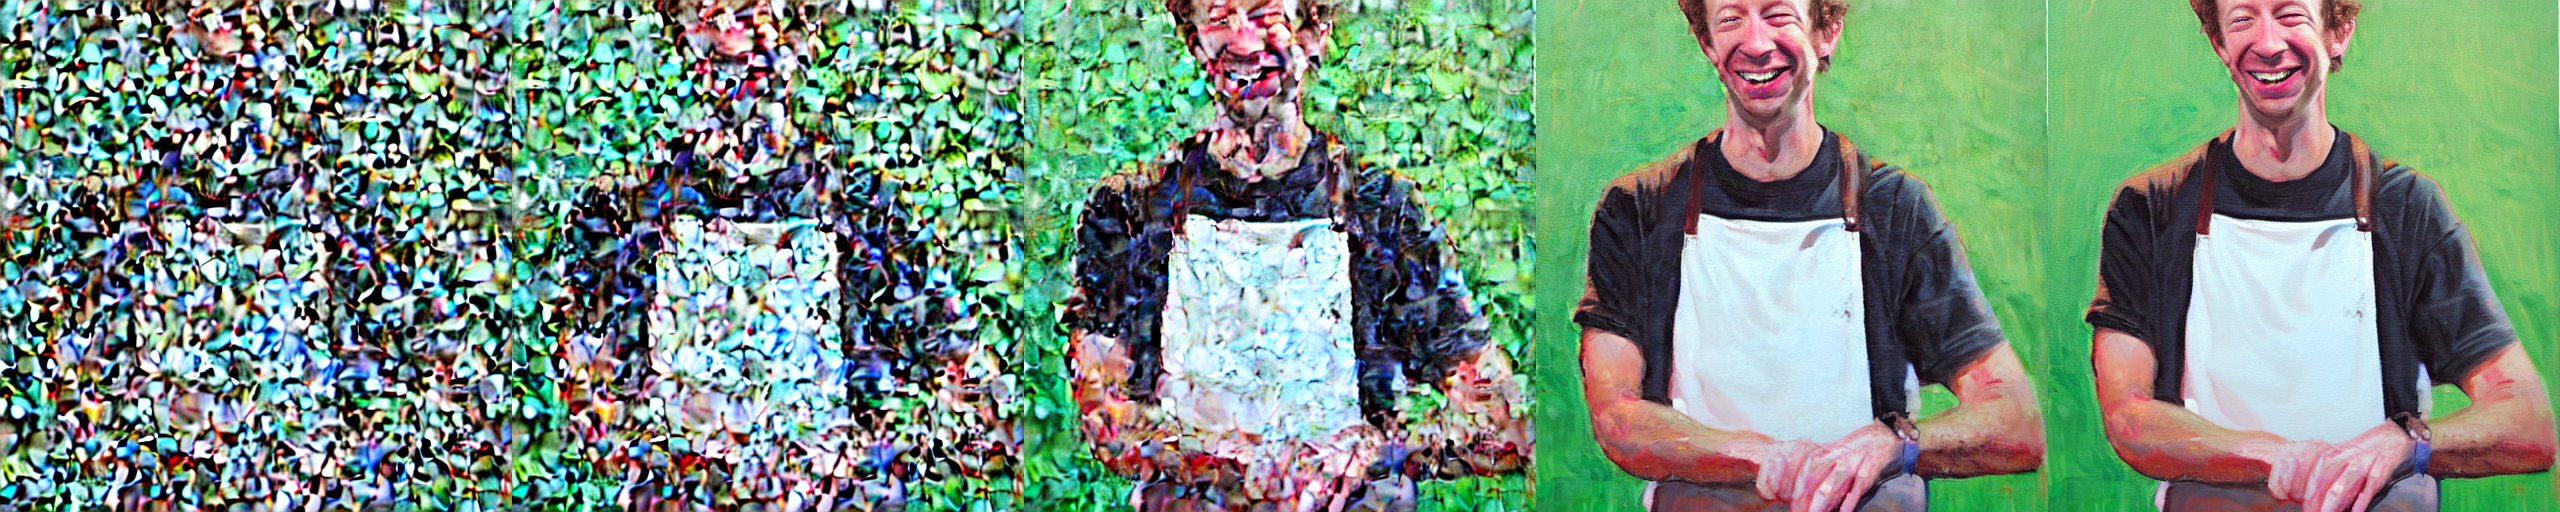

In [7]:
# Display
image_grid(images, rows=1, cols=len(images))  # adjust if needed

In [ ]:
del pipe #, pipe2
import gc
gc.collect()
if DEVICE == 'mps': torch.mps.empty_cache()
if DEVICE == 'cuda': torch.cuda.empty_cache()

In [22]:
def print_mps_mem(tag=""):
    alloc = torch.mps.current_allocated_memory() / 1024**2
    total = torch.mps.driver_allocated_memory() / 1024**2
    print(f"{tag} MPS allocated: {alloc:.2f} MB | driver total: {total:.2f} MB")

print_mps_mem()

 MPS allocated: 159.56 MB | driver total: 3151.58 MB


# Stable Diffusion XL (SDXL) 
is an advanced text-to-image generation model that produces high-quality, photorealistic images with detailed textures and colors. Key features include:

    High-resolution image generation (1024x1024)
    Advanced text understanding
    Improved realism and human anatomy
    Legible text generation
    Open source and free for commercial use

SDXL is suitable for artistic creation, content generation, and research.

`StableDiffusionXLPipeline` generates high-quality images from text prompts.
It generates images from text prompts, uses latent diffusion model for image generation, and can produce high-quality images with detailed textures and colors.

In [9]:
from diffusers import StableDiffusionXLPipeline

In [23]:
model_idXL2 = "stabilityai/stable-diffusion-xl-base-1.0"
pipe2 = StableDiffusionXLPipeline.from_pretrained(model_idXL2, variant='fp16', torch_dtype=FLOATTYPE).to(DEVICE)

r= pipe2(prompt="A New York landscape in ultra detail",
        height=768,
        width=768)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

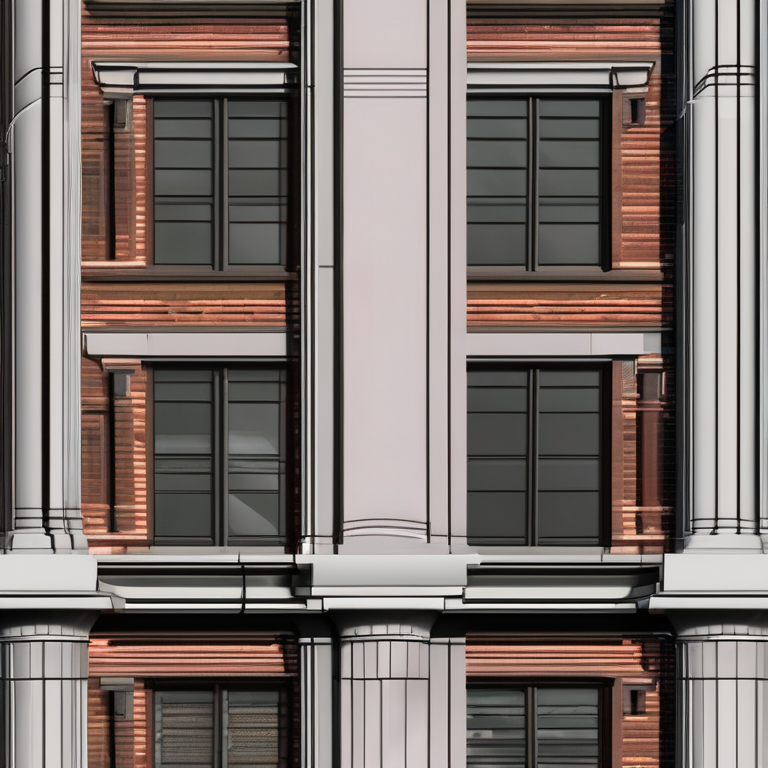

In [24]:
images = []
images.append(r.images[0])
image_grid(images, rows=1, cols=len(images))

In [5]:
print_mps_mem()

NameError: name 'print_mps_mem' is not defined

In [50]:
import os
try:
    os.remove(pipe)
except FileNotFoundError:
    print("Pipe does not exist")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: name 'pipe' is not defined


In [53]:
del pipe2
gc.collect()
if DEVICE == 'mps': torch.mps.empty_cache()
if DEVICE == 'cuda': torch.cuda.empty_cache()

NameError: name 'pipe2' is not defined

In [ ]:
model_id = "sd-legacy/stable-diffusion-v1-5" # stable-diffusion-v1-5/stable-diffusion-v1-5

with torch.autocast(DEVICE):
    pipe = StableDiffusionPipeline.from_pretrained(model_id, variant='fp16', torch_dtype=FLOATTYPE).to(DEVICE)
    
vae = pipe.vae
images = []

In [6]:
from diffusers import StableDiffusionXLPipeline
images = []
model_idXL2 = "stabilityai/stable-diffusion-xl-base-1.0"

def latents_callback(step: int, timestep, latents, pipe_args):
    #if not isinstance(latents, torch.Tensor) or latents.ndim != 4:
    #    print(f"Step {step}: latents are invalid or not ready (got shape {None if not isinstance(latents, torch.Tensor) else latents.shape})")
    #    return
    print ("Latents.ndim", latents.ndim)
    if latents.dim == 0: return;
    lat = latents[0:1] / 0.13025
    lat = lat.to(dtype=torch.float16, device=vae.device)

    with torch.no_grad():
        img = vae.decode(lat).sample[0]
        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.cpu().permute(1, 2, 0).numpy()
        images.extend(pipe.numpy_to_pil(img))
        print(f"Saved step {step}, timestep {timestep}")

with torch.autocast(DEVICE):
    pipe = StableDiffusionXLPipeline.from_pretrained(model_idXL2, variant='fp16', torch_dtype=FLOATTYPE).to(DEVICE)
vae = pipe.vae    

result = pipe(
    prompt="Portrait painting of Jeremy Howard looking sad.",
   height=768,
   width=768,
   num_inference_steps=25,
   callback_on_step_end=latents_callback,
   callback_on_step_end_interval=10,
    #generator=generator
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Latents.ndim 0


IndexError: Dimension specified as 0 but tensor has no dimensions

In [45]:
del pipe #, pipe2
if DEVICE == 'mps': torch.mps.empty_cache()
if DEVICE == 'cuda': torch.cuda.empty_cache()

NameError: name 'pipe' is not defined

Above are snapshots for creating “a smiling picture of Jeremy Howard”, printing the noise at steps 0, every 12 steps, 
and see the first signs of a face appear.  
In the early days this took a 1000 steps and now shortcuts make it take 60 steps. 
This doesn't look like normal noise because we are using VAE latents, which look like this.

**latent diffusion** is fast and efficient because the U-Net operates on a lower dimensional space, it reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in SD has a reduction factor of 8 but uses 4 channels instead of 3. Hence an image of shape `(3, 512, 512)` becomes `(4, 64, 64)` in latent space, which requires `8 × 8 × 3/4 = 48` times less memory. 
Hence it's possible to generate `512x512` images quickly. 

## Looking inside the pipeline
The [SD inference pipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L204) is a small piece of code that plugs the components together and performs the inference loop.
We'll go through the process of loading and plugging the pieces to see how we could have written it ourselves. 
We start by loading all the modules that we need from their pretrained weights.
First, we need the text encoder and the tokenizer, which come from the text portion of a standard CLIP model.
We'll use the weights released by Open AI.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

CLIPmodel_id = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(CLIPmodel_id, torch_dtype=FLOATTYPE)
text_encoder = CLIPTextModel.from_pretrained(CLIPmodel_id, torch_dtype=FLOATTYPE).to(DEVICE)

Next we'll load the `vae` and the `unet`. These are distinct models whose weights are stored inside folders of the SD repository. 
We use the `subfolder` argument to refer to [these HF locations](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main).

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae",torch_dtype=FLOATTYPE).to(DEVICE)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet",torch_dtype=FLOATTYPE).to(DEVICE)

### Scheduler
Next, we need a scheduler to converts "time steps" into the amount of noise.
The standard pipeline uses the [PNDM Scheduler](https://arxiv.org/abs/2202.09778), but we'll use the [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers/lms_discrete).
**NB:** We need to (be careful to) use the same noising schedule that was used during training. 
The schedule is defined by the number of noising steps and the amount of noise added at each step, which is derived from the _beta_ parameters.
We have to make sure that matches, so we use these numbers that we're given. 

In [ ]:
from diffusers import LMSDiscreteScheduler

LSconf = LMSDiscreteScheduler().config
LSconf

NB: JH said that 0.00085, 0.012  are given for beta_start and beta_end, but these don't correspond to the LMSDiscreteScheduler as returned by `.config`.

In [ ]:
import matplotlib.pyplot as plt

beta_start, beta_end = LSconf["beta_start"], LSconf["beta_end"] 
betas = torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2

plt.plot(betas)
plt.title('β SCHEDULE')
plt.xlabel('Timestep')
plt.ylabel('β')
plt.show()

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
#scheduler.config

We now define the parameters we'll use for generation.
In contrast with the previous examples, we set `num_inference_steps=70` to get an even more defined image.

In [ ]:
#prompt = ["a photograph of an astronaut riding a horse"]
prompt = ["an astronaut riding a black horse photorealistic 4K"]
height, width = 512, 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

### Step 1. Tokenize the prompt. 
The model requires the same number of tokens for every prompt, so padding (here `49407`) is used to meet the required length.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

The tokenizer returns a tuple of `inputs_ids`  (lookups into a vocabulary),
and `attention_mask` which tells it which ones are actual  words as opposed to padding.

In [ ]:
text_input.keys()

In [ ]:
len(text_input), text_input['input_ids'].shape, text_input['attention_mask'].shape

In [ ]:
tokenizer.decode(49407) # padding

In [ ]:
type(text_input)

In [ ]:
text_input['attention_mask']

## Step 2. Run thru the CLIP encoder
We can now take those input IDs, put them on the DEVICE, and run them through the CLIP encoder. 
The `text_encoder` returns (inference) the embeddings for the text prompt `text_input..[0]` that we used.

In [ ]:
text_embeddings = text_encoder(text_input.input_ids.to(DEVICE))[0]   # One image run thru the clip encoder
text_embeddings.shape   

And we got `text_embeddings` batch size 1 (one image) gives us a 77x768(77 tokens each 768 long vector). 
These are the CLIP embeddings for the prompt (e.g., "a photograph of an astronaut riding a horse").

[sander](https://sander.ai/2022/05/26/guidance.html)

For the [**Classifier-Free Guidance CFG**](https://sander.ai/2022/05/26/guidance.html) 
we also need to get the embeddings required to perform **unconditional** generation, which is achieved with an **empty string** "". <br>
The model is free to go in whichever direction it wants as long as it results in a reasonably-looking image.

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(DEVICE))[0]
uncond_embeddings.shape

For CFG, we need to do two forward passes:
One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`).<br>
In practice (to improve GPU performance), we can concatenate `torch.cat` both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

## Step 3. Denoising
We start the denoising process from pure Gaussian (normal) noise, i.e., normally distributed random numbers of size one (our batch size).
These are our initial `latents`.... but they are just noise.
We divide height and weight by 8 because that is what the VAE does; 
It allows us to create things that are 8x smaller by height and width, then it will expand it up again later, that's why this is so much faster.
After we put it on the GPU, `.half()` is converting into half precision (fp_16), making it half as big in RAM, modern GPUs are faster if we do that.

In [ ]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8))
latents = latents.to(DEVICE).half()
latents.shape

`4×64×64` is the input shape. The decoder will later transform this latent representation into a `3×512×512` image after the denoising process is complete.

Next, we initialize the scheduler with our chosen `num_inference_steps` (e.g. 70). This will prepare the internal state to be used during denoising.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

We **scale** the initial (random) noise by the standard deviation required by the scheduler, to get the "right" amount of variance.
This value `init_noise_sigma` depends on the particular scheduler we use.

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. 
The timesteps go from `999` to `0` (1000 steps that were used during training) following a particular schedule.<br>
NB: They're not "time steps", they're not integers, is a confusing term.
It's just a measure of how much noise we are adding at each time.  
(This particular schedule allows us to skip many steps)

In [ ]:
scheduler.timesteps  # badly named

 and we find out how much noise by looking it up in `.sigmas`

In [ ]:
scheduler.sigmas # The actual amount of noise

In [ ]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

Now we go through the (70) timesteps in a for loop 
```python
for i, t in enumerate(tqdm(scheduler.timesteps)):
```
concatenating our two noise bits together, ```input_ts = torch.cat([latents] * 2)```
because we've got the classifier free and the prompt versions.<br>
Then do the scaling, ```input = scheduler.scale_model_input(input_ts, t)``` to get predictions from the `unet` (passing in the "timestep" `t` and the prompt `text_embeddings`). <br>
```Python
 with torch.no_grad():
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample
```
The `unet` returns the 2 parts of the guidance, for the empty string and for the caption.
We pull them apart with `.chunk(2)` into 2 separate variables:
```pred_uncond, pred_text = pred.chunk(2)```<br>
Now we can do the guidance scale (7.5) 
```pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)```<br>
and update to get the new latents, i.e., compute the previous noisy sample $x_t \rightarrow x_{t-1}$
```Python
latents = scheduler.step(pred, t, latents).prev_sample
```    

In [ ]:
from tqdm.auto import tqdm

for i, ts in enumerate(tqdm(scheduler.timesteps)):
    input_ts = torch.cat([latents] * 2).to(torch.float16)
    input = scheduler.scale_model_input(input_ts, ts)

    # predict the noise residual
    with torch.no_grad():
        pred = unet(input, ts, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)   #pull them apart
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the previous noisy sample x_ts -> x_ts-1
    latents = scheduler.step(pred, ts, latents).prev_sample

After the `for` loop above completes, the `latents` contain a denoised representation of the image. Per paper, we need to divide it by `0.18215` to scale it correctly.
Then use `vae_decode` to convert it back to pixel space. 

In [ ]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image.shape

The *Python Imaging Library* expects unsigned integers between (0,255), and it expects a different order.
Now we have numbers between -1 and 1, so we shift them right (x/2 + 0.5) and `clamp`, then permute the axes, and convert to the right range and type (`uint8`).

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1,2,0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Just the Code
combined in one single  screen at once, and some simplifications (eg variable names)

In [ ]:
prompts = [
    'a 4K photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [ ]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(DEVICE))[0].half()

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(DEVICE))[0].half()
emb = torch.cat([uncond_embeddings, text_embeddings])

Coding best practice: Software Engineers like long words as variable names, mathematicians like short, e.g., letters.
Turning long variable names to single letters makes it easier to experiment, understand how it behaves,
manipulate algebraically and make it look like the paper.<br>
`g` is guidance scale, and `u, t` the unconditional and text embeddings.

In [ ]:
torch.manual_seed(100)
g = guidance_scale

In [ ]:
latents = torch.randn((len(prompts), unet.config.in_channels, height//8, width//8))
scheduler.set_timesteps(num_inference_steps)
latents = latents.to(DEVICE).half() * scheduler.init_noise_sigma

In [ ]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): 
        u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

In [ ]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

In [ ]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

In [ ]:
image = res[1].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Put it in functions
Now everything fits in the 2 cells below

In [ ]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(DEVICE))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [ ]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.config.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(DEVICE).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [ ]:
images = mk_samples(prompts, steps=100, seed=1000)

In [ ]:
from IPython.display import display
for img in images: display(mk_img(img))

## homework
- Implement one of the extra tricks we learned (image to image or negative prompts),
- adding callbacks  (don't need to wait for the diffusers folks to update the library)

### Implement negative_prompt